In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import time
from model.pspunet import pspunet
from util.angle import *
from util.depth import *
from util.path import *
from visualizer import *
from util.object_dection import *

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
       gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

        
IMG_WIDTH = 480
IMG_HEIGHT = 272
n_classes = 7

model = pspunet((IMG_HEIGHT, IMG_WIDTH ,3), n_classes)
model.load_weights("pspunet_weight.h5")

ANGLE_CLASS = 15

ANGLE = angle_dict(ANGLE_CLASS)

data = np.load("video_data.npz")
data = data["arr_0"]

img = data[:,0,:,:,:]
point_cloud = data[:,1,:,:,:]

In [ ]:
'''fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('yolo2.mp4', fourcc, 25.0, (480, 270))

cap = cv2.VideoCapture("video.mp4")
while True:
    start_time = time.time()
    _, img = cap.read()
    yolo_img, _ = YOLO(img.copy())
    cv2.imshow("",yolo_img)
    cv2.waitKey(1)
    out.write(yolo_img)
    print(1/(time.time()-start_time))
out.release()'''

In [ ]:
for i in range(500, 1101):
    start = time.time()
    visualize(model, img[i], point_cloud[i], 5, 2.5, ANGLE, ANGLE_CLASS)
    plt.savefig('selly_vision_video/image_at_epoch_{:04d}.png'.format(i))
    print(time.time() -start)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


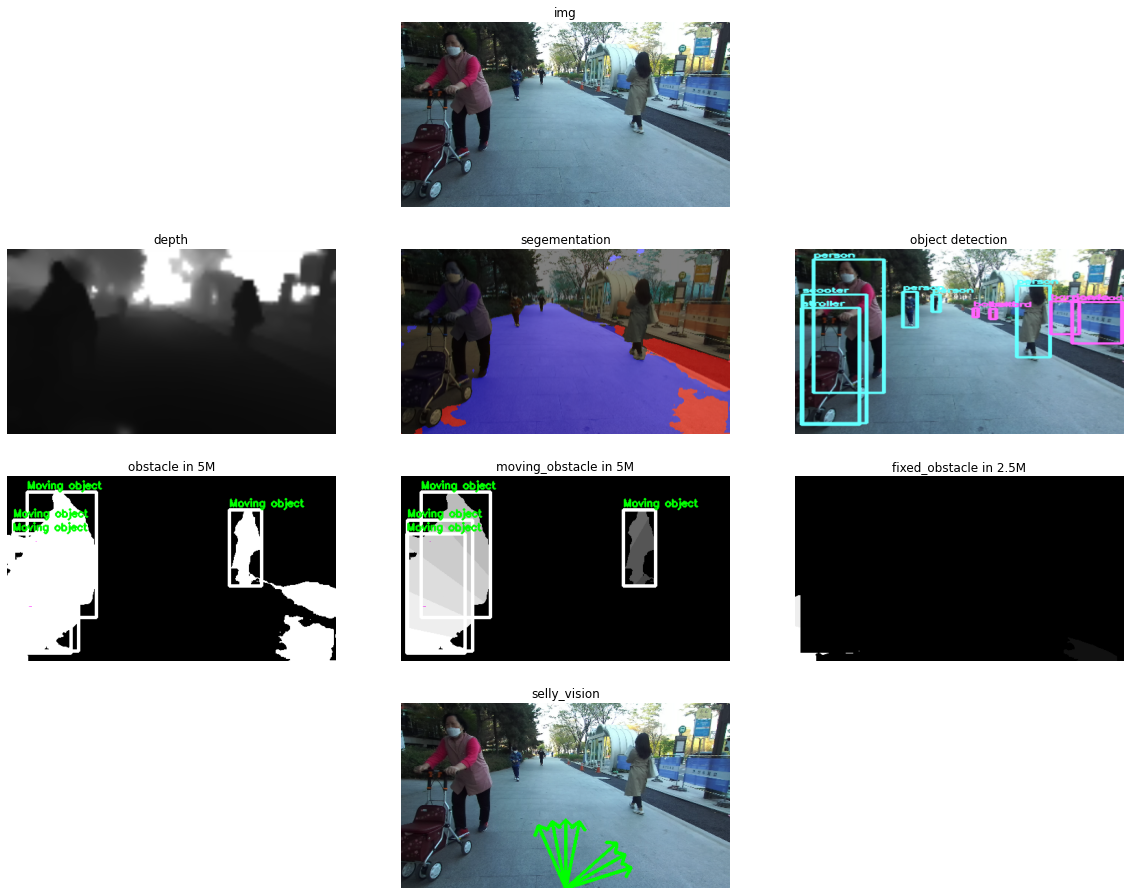

In [13]:
i = 146
visualize(model, img[i], point_cloud[i], 5, 2.5, ANGLE, ANGLE_CLASS)

In [11]:
i = 169
start = time.time()
selly_vision_img(model, img[i], point_cloud[i], 5, 2.5, ANGLE, ANGLE_CLASS)[0]/255
print(time.time() -start)

0.09749150276184082


In [22]:
selly_vision_img(model, img[i], point_cloud[i], 5, 2.5, ANGLE, ANGLE_CLASS)[1]

[24.0, 36.0, 48.0, 84.0, 96.0, 108.0, 120.0]

In [6]:
for i in range(500, 1101):
    start = time.time()
    plt.figure()
    plt.imshow(RGB(selly_vision_img(model, img[i], point_cloud[i], 5, 2.5, ANGLE, ANGLE_CLASS))/255)
    plt.savefig('selly_vision_video/image_at_epoch_{:04d}.png'.format(i))
    print(time.time() -start)

TypeError: Expected Ptr<cv::UMat> for argument 'src'

<Figure size 432x288 with 0 Axes>

In [ ]:
#동영상 녹화
import os 

vision_img_list = os.listdir("selly_vision_video/")

max_dist = 5
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('selly_vision2.mp4', fourcc, 10.0, (480, 270))
vision_img_list.sort()
for idx in range(1101):
    start_time = time.time()
    vision_img = cv2.imread("selly_vision_video/"+vision_img_list[idx])
    out.write(vision_img)
    print(time.time()-start_time)
    
out.release()

In [ ]:
out.release()
